A competing risk model is used to analyze the occurrence of multiple events. There are two or more possible outcomes that compete with each other for occurrence, and the probability of one outcome may affect the probability of another.

When there are competitive risk events, the traditional survival analysis method will overestimate the risk of the disease, resulting in competitive risk bias. For example, a patient can die from breast cancer or from stroke, but he cannot die from both. 

Competing risk model aims to correctly estimate marginal probability of an event in the presence of competing events. The following figures illustrate the comparison of end events between the two processes.

<table>
<td> 
<img src="./Figure/tradition_survival.png" style="width:100;height:200px;"> <br>
<center> Figure 1: Traditional survival analysis process<center>
</td> 
<td> 
<img src="./Figure/competing_risk_model.png" style="width:300;height:400px;"> <br>
<center> Figure 2: Competing risk process<center>
</td> 
</table>

Let $T$ and $C$ be the failure and censoring times, and $\epsilon\in\{1,\ldots,K\}$ be cause of failure. The observed time is $X=\min\{T, C\}$, censoring indicator is $\delta=I(T\leq C)$. For the type $k$ failure, the subdistribution hazard is defined as following,
$$\lambda_k(t;\boldsymbol{Z})=\underset{\Delta t\to 0}{\lim} \frac{1}{\Delta t} P(t\leq T\leq t+\Delta t, \epsilon=k| (T\geq t)\cup (T<t\cap \epsilon\neq k), \boldsymbol{Z}),$$
where $\epsilon\in\{1,\ldots,K\}$ is the cause of failure, $\mathbf{Z}$ is the covariates and $\boldsymbol{\beta}$ is a vector of unknown regression parameters. It leads to the following log partial likelihoood,
$$log(L(\boldsymbol{\beta}))=\sum_{i=1}^n I(\epsilon_i=k,\delta_{i}=1)\left\{\boldsymbol{\beta}^{\prime}\boldsymbol{Z}_i-\log\left[\sum_{j\in R_i}\exp(\boldsymbol{\beta}^{\prime}\boldsymbol{Z}_j)\right]\right\},$$
where $R_i=\{j: (X_j\geq T_i)\cup (T_j\leq T_i\leq C_j \cap \epsilon_i\neq k)\}$ is the at risk set at time $X_i$

In the simulation part, similar to [1]_, we only consider two types of failure. The vector of regression parameters for case 1 is $\boldsymbol{\beta}_1$, and for case 2 is $\boldsymbol{\beta}_2=-\boldsymbol{\beta}_1$. This suggests that the subdistributions for type 1 failures were given by
$$P(T\leq t,\epsilon=1|\boldsymbol{Z})=1-\left[1-p(1-e^{-t})\right]^{\exp(\boldsymbol{\beta_1}^{\prime}\boldsymbol{Z})}.$$
The case 2 failures are obtained by $P(\epsilon=2|\boldsymbol{Z})=1-P(\epsilon=1|\boldsymbol{Z})$ and then using an exponential distribution with rate $\exp(\boldsymbol{\beta_2}^{\prime}\boldsymbol{Z})$. 

In [29]:
import numpy as np
import random
import jax.numpy as jnp
from scope import ScopeSolver

# generate the above data
# mix: the value of p in the subdistribution
# c: the censoring times generated from a uniform on [0,c]
def make_data(n,beta,rho=0.5,mix=0.5,c=10):
    p = len(beta)
    Sigma = np.power(rho, np.abs(np.reshape(np.array([i-j for i in np.arange(1,p+1) for j in np.arange(1,p+1)]) ,newshape=(p,p))))
    x = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=(n,))
    Xbeta = np.matmul(x, beta)
    prob = 1 - np.power((1-mix), np.exp(Xbeta))
    case =  np.random.binomial(1,prob)             # failure case
    u = np.random.uniform(0, 1, n)
    temp = -(1-mix)/mix+np.power((1-u+u*np.power((1-mix),np.exp(Xbeta))),np.exp(-Xbeta))/mix
    time = case*(-np.log(temp))  + (1-case)*np.random.exponential(np.exp(-Xbeta),n)
    ctime =  np.random.uniform(0, c, n)
    delta = (time < ctime) * 1              # censoring indicator
    censoringrate = 1 - sum(delta) / n
    print("censoring rate:" + str(censoringrate))
    time = np.minimum(time,ctime)
    y = np.hstack((time.reshape((-1, 1)), ctime.reshape((-1, 1))))
    delta = np.hstack((delta.reshape((-1, 1)), case.reshape((-1,1))))
    return(x,y,delta)

Considering the sparsity, under sparsity constraint, we can estimate $\boldsymbol{\beta}$ by minimizing the negative log partial likelihood function:
$$arg\min_{\beta \in R^p}~-log L(\boldsymbol{\beta}) , s.t.  || \boldsymbol{\beta}||_0 \leq s.$$
Firstly, generate the data as described above and plot Kaplan-Meier survival curves. Then, perform a log-rank test to compare the survival curves of the two groups. The following results show that there is a significant difference between the survival curves.

censoring rate:0.385


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         192.08 <0.005    142.69

None


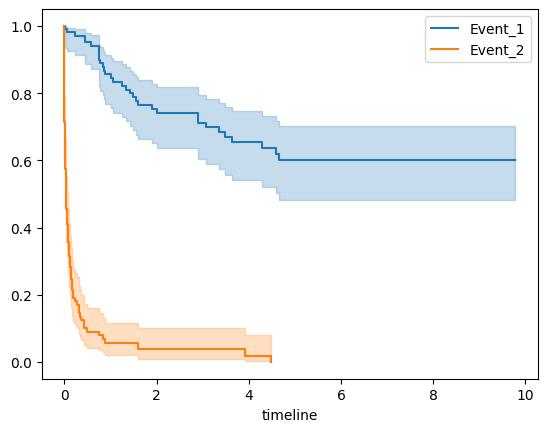

In [32]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

n, p, k = 200, 10, 2
beta = np.zeros(p)
supportset = random.sample(range(0,p),k)
beta[supportset] = np.random.uniform(2, 5, k)
x,y,delta = make_data(n,beta)

kmf = KaplanMeierFitter()
for i in range(0, 2):
    event_name = 'Event_' + str(i+1)
    kmf.fit(y[delta[:,1]==i,0], delta[delta[:,1]==i,0], label=event_name, alpha=0.05)
    kmf.plot()

results = logrank_test(y[delta[:,1]==0,0], y[delta[:,1]==1,0], delta[delta[:,1]==0,0], delta[delta[:,1]==1,0])
print(results.print_summary())

A python code for solving such model is as following: 

In [19]:
n, p, k = 200, 10, 2
beta = np.zeros(p)
supportset = random.sample(range(0,p),k)
beta[supportset] = np.random.uniform(2, 5, k)
x,y,delta = make_data(n,beta)

def competing_risk_objective(params):
    Xbeta = jnp.matmul(x, params)
    logsum = jnp.zeros_like(Xbeta)
    for i in range(0,n):
        riskset = ((y[:,0]>=y[i,0])|((delta[:,1]==0)&(delta[:,0]==1)&(y[:,0]<=y[i,0])&(y[:,1]>=y[i,0])))*1
        logsum = logsum.at[i].set(jnp.log(jnp.dot(riskset, jnp.exp(Xbeta))))
    return jnp.dot(delta[:,0]*delta[:,1],logsum)/n-jnp.dot(delta[:,0]*delta[:,1], Xbeta)/n


solver = ScopeSolver(p, k)
solver.solve(competing_risk_objective, jit=True)
print("Estimated parameter:", solver.get_result()["params"], "objective:",solver.get_result()["value_of_objective"])
print("True parameter:", beta, "objective:",competing_risk_objective(beta))

censoring rate:0.365
Estimated parameter: [2.26908371 0.         0.         0.         0.         3.61334751
 0.         0.         0.         0.        ] objective: 1.4893887042999268
True parameter: [2.33791115 0.         0.         0.         0.         3.42582937
 0.         0.         0.         0.        ] objective: 1.4933996


The algorithm has selected the correct variables, and the estimated coefficients and loss are very close to the true values.

.. rubric:: References
.. [1] Jason P. Fine & Robert J. Gray (1999) A Proportional Hazards Model for the Subdistribution of a Competing Risk, Journal of the American Statistical Association, 94:446, 496-509